# Tests

In [38]:
import EZlem as ezlem
import matplotlib.pyplot as plt

import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test sinkfill on initially flat grid

In [39]:
model = ezlem.simple_model()
Zi = model.Z.copy()

In [40]:
model.sinkfill()

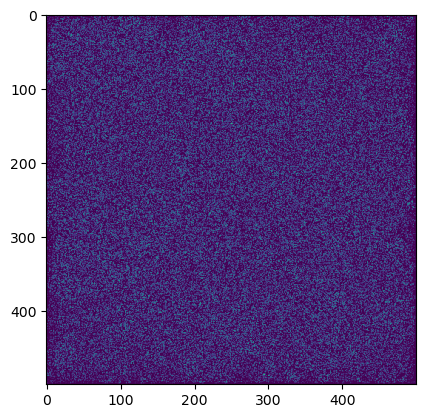

In [41]:
plt.imshow(model.Z-Zi)

In [42]:
assert(np.all(model.Z-Zi>=0)) ## Assert that we are filling every cell

## Compare filling results to richdem - skip if cannot install richdem

In [43]:
import richdem
Z = richdem.rdarray(Zi,no_data=0)
Z_rich = richdem.ResolveFlats(richdem.FillDepressions(Z))

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood (Zhou2016 version)
C Zhou, G., Sun, Z., Fu, S., 2016. An efficient variant of the Priority-Flood algorithm for filling depressions in raster digital elevation models. Computers & Geosciences 90, Part A, 87 – 96. doi:http://dx.doi.org/10.1016/j.cageo.2016.02.021

t Zhou2016 wall-time = 0.0316798 s

A Barnes (2014) Flat Resolution Flat Mask Generation
C Barnes, R., Lehman, C., Mulla, D., 2014a. An efficient assignment of drainage direction over flat surfaces in raster digital elevation models. Computers & Geosciences 62, 128–135. doi:10.1016/j.cageo.2013.01.009

t Succeeded in = 0.00299679 s
p Setting up labels matrix...
p Setting up flat resolution mask...
p Searching for flats...
t Succeeded in = 0.00593537 s=================] (100% - 0.0s - 1 threads)
m Cells with no flow direction = 97921
m Low edge cells               = 4773
m High edge cells              = 97847
p Labeling flats...
m Unique flats = 4774
p Removing flats without outlets from the queue...
  The flat

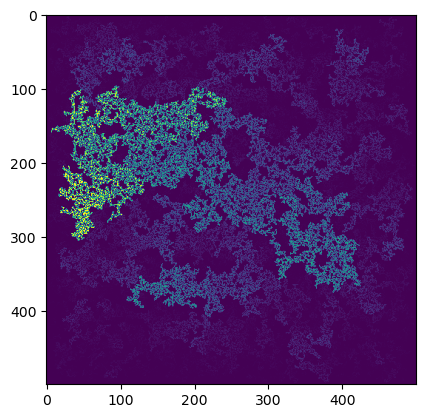

In [44]:
plt.imshow(np.abs(Z_rich - model.Z),vmin=0,vmax=.001) #should be extremely minor differences

In [45]:
assert((np.sum(np.abs((Z_rich-Zi) - (model.Z-Zi))/np.sum(np.abs(model.Z-Zi)))<1e-3)) # We want there to be less than 0.1% difference in the volume filled

## Flowacc

In [46]:
model.set_z(Z_rich)
model.slp()
model.stack()
model.acc()

0


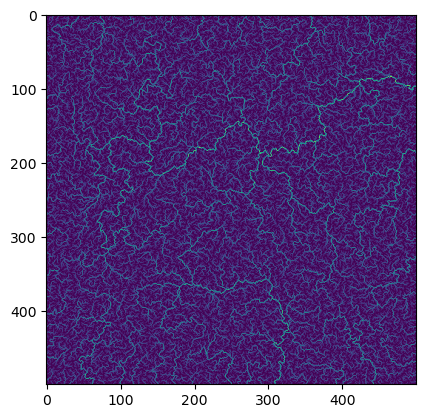

In [47]:
plt.imshow(np.log(model.A))

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood (Zhou2016 version)
C Zhou, G., Sun, Z., Fu, S., 2016. An efficient variant of the Priority-Flood algorithm for filling depressions in raster digital elevation models. Computers & Geosciences 90, Part A, 87 – 96. doi:http://dx.doi.org/10.1016/j.cageo.2016.02.021

t Zhou2016 wall-time = 0.0324003 s

A Barnes (2014) Flat Resolution Flat Mask Generation
C Barnes, R., Lehman, C., Mulla, D., 2014a. An efficient assignment of drainage direction over flat surfaces in raster digital elevation models. Computers & Geosciences 62, 128–135. doi:10.1016/j.cageo.2013.01.009

t Succeeded in = 0.00304933 s
p Setting up labels matrix...
p Setting up flat resolution mask...
p Searching for flats...
t Succeeded in = 0.00599563 s=================] (100% - 0.0s - 1 threads)
m Cells with no flow direction = 97921
m Low edge cells               = 4773
m High edge cells              = 97847
p Labeling flats...
m Unique flats = 4774
p Removing flats without outlets from the queue...
  The flat

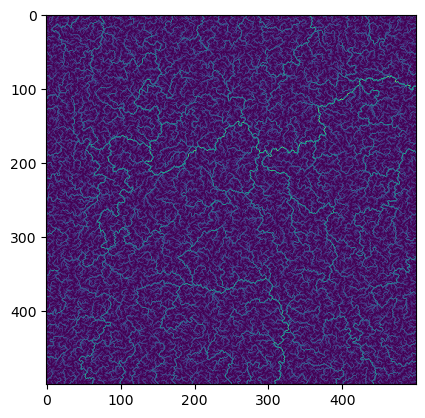

In [48]:
A = richdem.FlowAccumulation(richdem.ResolveFlats(richdem.FillDepressions(Z)),method='D8')
plt.imshow(np.log(A)) 

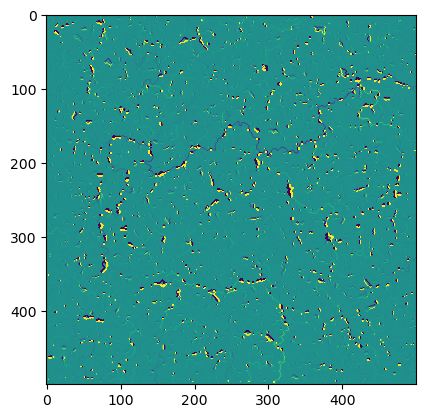

In [49]:
plt.imshow(model.A - A,vmin=-100,vmax=100) #Difference appears to be due to how flats are resolved - that said, there is not much difference in the totals

In [50]:
assert((np.max(model.A)-np.max(A))/np.max(A)<.01)#Want to make sure there is less than 1% difference in the drainage area of the largest basin

## Compare to landlab - skip if cannot install landlab

In [51]:
import rasterio as rio

In [52]:
Zi = np.random.rand(20, 20)+.01
Zi[~(Zi>0)]=0

In [53]:
m,n=np.shape(Zi)

In [54]:
from landlab import RasterModelGrid, imshow_grid
from landlab.components import FlowAccumulator, FastscapeEroder,LinearDiffuser
import numpy as np


mg = RasterModelGrid((m, n), xy_spacing=(1.0, 5.0))
Zi2 = Zi.copy()

Zi2 = mg.add_field("topographic__elevation", Zi2, at="node")
mg.set_closed_boundaries_at_grid_edges(False, False, False, False)
fa = FlowAccumulator(
     mg,
     'topographic__elevation',
     flow_director='FlowDirectorD8'
     )
fa.run_one_step()
A0 = mg.at_node['drainage_area']
sp = FastscapeEroder(mg, K_sp=1e-6, n_sp = 1)
sp.run_one_step(dt=10)

/Users/gr_1/miniconda3/envs/globolem3/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [55]:
model = ezlem.simple_model()
model.set_z(Zi.copy())#np.array(out_ds.topography__elevation[0]))
model.t = 10
model.dt = 10
model.dx = 1
model.dy = 5
# model.BCX = np.zeros((20,20),dtype=np.int64)
# model.BCX[:, 0] = 1
# model.BCX[:, -1] = 1
# model.BCX[0, :] = 1
# model.BCX[-1, :] = 1
model.BC = np.where(model.BCX == 1)[0]
#model.BC= np.zeros(0,dtype=np.int64)
model.k = np.zeros(np.shape(model.Z))+1e-6
model.slp_basin()
model.stack()
model.acc()
model.erode()

33


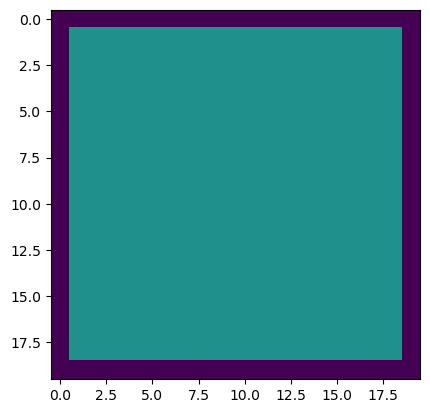

In [56]:
plt.imshow(A0.reshape(m,n)/5/model.A,vmin=.99,vmax=1.01)

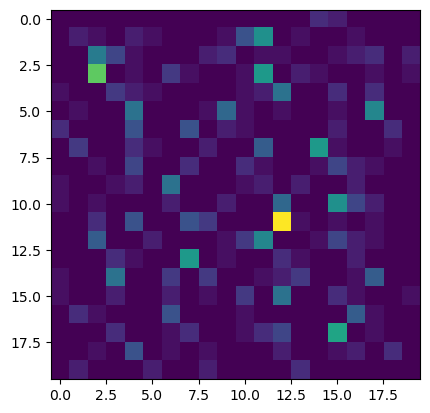

In [57]:
plt.imshow(model.A)

In [58]:
E1 = -model.Z + Zi.reshape(20,20)
E2 = -Zi2.reshape(20,20) + Zi.reshape(20,20)

In [59]:
assert(np.all(np.abs(E1-E2)<1e-8)) #Should be near zero everywhere

In [60]:
E = ezlem.erode_explicit(model.slps, model.I, model.s, model.A, np.zeros(np.shape(model.slps)), dx=1, dy=5.00, m=0.5, n=1.0, k=np.zeros(np.shape(model.Z))+1e-6, dt=10, carea=0, G=0);

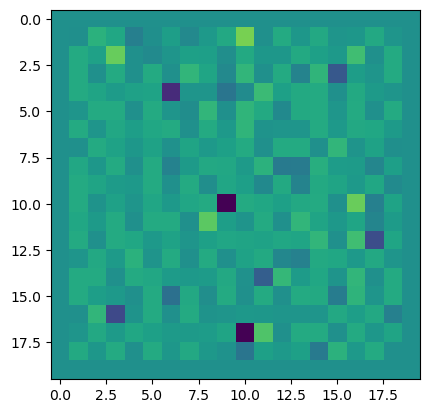

In [61]:
plt.imshow((E-E1)/(E1+.00000001),vmin=-.0001,vmax=.0001) #Should be some minor differences (but mostly zeros)

In [62]:
np.max(E1)

2.034236141534862e-05

## Compare Diffusion

In [63]:
mg = RasterModelGrid(np.shape(Zi), xy_spacing=(1.0, 5.0))
Zi2 = mg.add_field("topographic__elevation", Zi.copy(), at="node")
mg.set_closed_boundaries_at_grid_edges(False, False, False, False)
ld = LinearDiffuser(mg, linear_diffusivity=1e-3, method='simple', deposit= True)
ld.run_one_step(dt=10)

/Users/gr_1/miniconda3/envs/globolem3/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


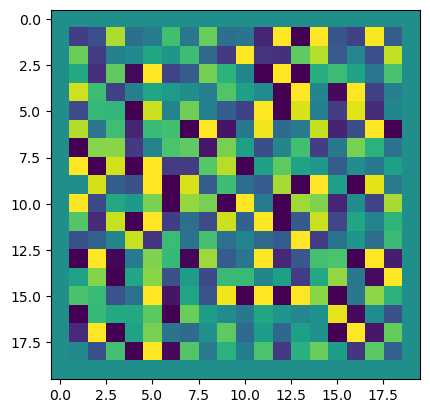

In [64]:
E2 = -Zi2.reshape(20,20) + Zi.reshape(20,20)
plt.imshow(E2, vmin=-.01, vmax=.01)

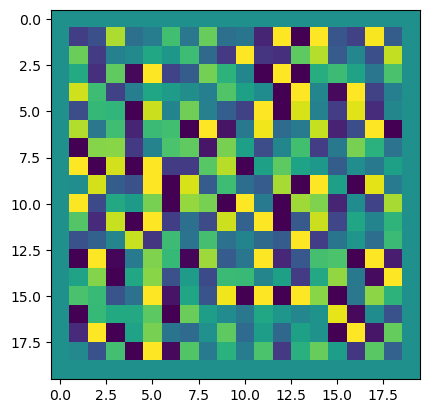

In [65]:
E = ezlem.diffuse(Zi.copy(),D=1e-3, dy=5, dx=1, dt=10)
plt.imshow(E, vmin=-.01, vmax=.01)


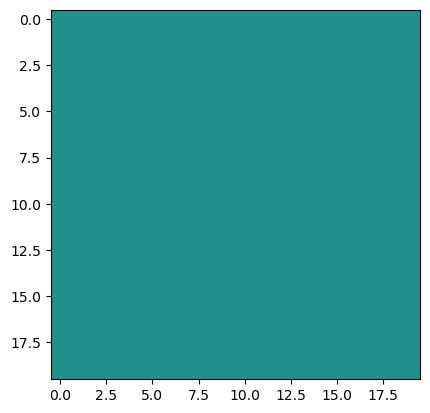

In [68]:
plt.imshow((E2-E)/(E+1e-9),vmin=-0.001,vmax=.001) # SHould be the same

In [69]:
assert(np.linalg.norm(E2-E)<1e-5)